### Exemplo de teste de hipótese com Bootstraping

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(10)

# Imagine um experimento com os seguintes resultados:
controle= np.random.randint(5,30,250)
tratamento= np.random.randint(5,34,250)

In [94]:
# A média do controle
media_controle_observada = controle.mean()
media_controle_observada

17.88

In [95]:
# A média do tratamento
media_tratamento_observada = tratamento.mean()
media_tratamento_observada

19.404

In [96]:
# Será que essa diferença de médias observadas é significativa?
diff_medias = media_tratamento_observada - media_controle_observada
diff_medias

1.524000000000001

#### Teste de Hipótese

Iremos testar se o tratamento é maior que o controle (teste unicaudal)

In [97]:
# Tamanho dos vetores tratamento e controle
n_controle = len(controle)
n_tratamento = len(tratamento)

# Concatenando os vetores para ter uma única distribuição
distribuicao_unica = np.concatenate((controle, tratamento))

In [98]:
# Aqui são realizadas as simulações para o cálculo do p-valor. 

n_simulacoes = 10000
vetor_diferenca_medias = [None]*n_simulacoes

for ii in range(0,n_simulacoes):
    
    simul_controle = np.random.choice(distribuicao_unica, n_controle, replace=True)
    simul_tratamento = np.random.choice(distribuicao_unica, n_tratamento, replace=True)
    vetor_diferenca_medias[ii]= simul_tratamento.mean() - simul_controle.mean()    

Ao concatenarmos os vetores de tratamento e controle e pegarmos valores aleatórios dentro dessa nova distribuição, estamos simulando o caso em que a hipótese nula é verdadeira, ou seja, de fato os dois grupos são iguais

O vetor_diferenca_medias contém a diferença de médias observadas na simulação, sob a hipótese que os dois vetores (tratamento e controle) são iguais.

Abaixo, o histograma do vetor de diferenças da simulação. 
- Note que os valores estão concentrados ao redor de 0 (o que é esperado, dado que fizemos samples da mesma distribuição)
- Repare na dispersão dos dados e como a maioria se encontra entre -2,0 e 2,0

Apenas olhando para esta distribuição, tente responder: você acha que a diferença de médias observadas entre o controle e tratamento inicial de 1,52 é significativa? Qual parece ser a chance de esse valor ter sido gerado por distribuições de tratamento e controle iguais (hipótese nula)?


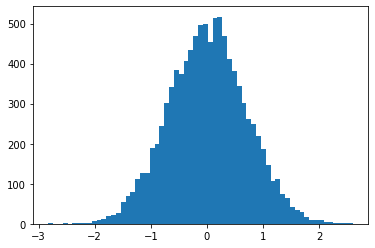

In [99]:
_ = plt.hist(vetor_diferenca_medias, bins='auto')
plt.show()

Note que, nesta simulação, algumas diferenças de médias de fato foram próximas da observada de 1,52 e até mais extremos do que isso. Ou seja, mesmo assumindo que as duas distribuições são iguais, ainda sim em alguns poucos casos observamos diferenças de médias dessa ordem.

Ao mesmo tempo, note que se a diferença entre tratamento e controle inicial fosse 0,3 ao invés de 1,52, estaríamos em uma região bem mais frequente do histograma acima. Ou seja, neste caso, assumindo a hipótese nula, fomos capazes de observar várias situações em que a diferença de médias foi 0,3 ou mais extremo.

O p-valor é justamente essa medida: a chance de obter valores mais extremos sob a hipótese nula.


In [100]:
# A quantidade de vezes que foi obtido valores tão ou mais extremos foi:
n_extremos = len(np.where(vetor_diferenca_medias >= diff_medias)[0])
n_extremos

147

In [101]:
# De um total de 10000 simulações, apenas 147 foram tão ou mais extremas do que o valor observado. Ou seja, o pvalor é de:
pvalor = n_extremos/ n_simulacoes
pvalor

0.0147

Ou seja, ao afirmamos que a média da distribuição do tratamento é maior que a do controle, temos 1,47% de chance de estarmos fazendo uma afirmação falsa, conforme demonstrado na nossa simulação acima.

Para um video introdutório sobre teste de hipótese usando bootstrapping, veja: https://www.youtube.com/watch?v=isEcgoCmlO0